# Monad pipeline
For BP purposes

Norbert Matuška

In [38]:
import pandas as pd
import numpy as np
import base64
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation and analysis

Decodes and parses 802.11 wireless frame headers, extracting details like frame type, MAC addresses, and sequence information. It categorizes management, control, and data frames.

In [39]:
management_subtypes = {
    0:  "Association Request",
    1:  "Association Response",
    2:  "Reassociation Request",
    3:  "Reassociation Response",
    4:  "Probe Request",
    5:  "Probe Response",
    6:  "Timing Advertisement (11v)",
    7:  "Reserved",
    8:  "Beacon",
    9:  "ATIM",
    10: "Disassociation",
    11: "Authentication",
    12: "Deauthentication",
    13: "Action",
    14: "Action No Ack (11e)",
    15: "Reserved"
}

control_subtypes = {
    0:   "Reserved",
    1:   "Reserved",
    2:   "Trigger",
    3:   "TACK",
    4:   "Beamforming Report Poll",
    5:   "VHT/HE NDP Announcement",
    6:   "Reserved",
    7:   "Control Wrapper",
    8:   "Block Ack Request",
    9:   "Block Ack",
    10:  "PS-Poll",
    11:  "RTS",
    12:  "CTS",
    13:  "ACK",
    14:  "CF-End",
    15:  "CF-End + CF-Ack"
}

data_subtypes = {
    0:   "Data",
    1:   "Data + CF-Ack",
    2:   "Data + CF-Poll",
    3:   "Data + CF-Ack + CF-Poll",
    4:   "Null Function (No Data)",
    5:   "CF-Ack (No Data)",
    6:   "CF-Poll (No Data)",
    7:   "CF-Ack + CF-Poll (No Data)",
    8:   "QoS Data",
    9:   "QoS Data + CF-Ack",
    10:  "QoS Data + CF-Poll",
    11:  "QoS Data + CF-Ack + CF-Poll",
    12:  "QoS Null",
    13:  "Reserved",
    14:  "Reserved",
    15:  "Reserved"
}

frame_type_map = {
    0: "Management",
    1: "Control",
    2: "Data",
    3: "Extension"
}

TRANSLATED_HEADER_COLUMNS = [
    "frame_control_raw",
    "protocol_version",
    "frame_type",
    "subtype",

    "to_ds",
    "from_ds",
    "more_frag",
    "retry",
    "power_mgmt",
    "more_data",
    "protected_frame",
    "order_flag",

    "duration_id",

    "destination_mac",
    "source_mac",
    "bssid_mac",
    "address4_mac",

    "sequence_control_raw",
    "fragment_number",
    "sequence_number",

    "qos_control_raw",
    "ht_control_raw",

    "frame_body"
]


def decode_header(header_b64):
    try:
        return base64.b64decode(header_b64)
    except Exception as e:
        print(f"Error decoding header: {e}")
        return None

def parse_probe_request(frame_body):

    pos = 0
    ies = {
        "ssid": None,
        "supported_rates": [],
        "extended_rates": [],
        "vendor_specific": []
    }

    while pos < len(frame_body):
        if pos + 1 >= len(frame_body):
            break

        element_id = frame_body[pos]
        element_len = frame_body[pos + 1]
        pos += 2

        if pos + element_len > len(frame_body):
            break

        element_data = frame_body[pos : pos + element_len]
        pos += element_len

        if element_id == 0:
            ies["ssid"] = element_data.decode("ascii", errors="ignore")
        elif element_id == 1:
            ies["supported_rates"] = _decode_supported_rates(element_data)
        elif element_id == 50:
            ies["extended_rates"] = _decode_supported_rates(element_data)
        elif element_id == 221:
            ies["vendor_specific"].append(element_data)
        else:
            pass

    return ies

def _decode_supported_rates(rate_bytes):

    rates = []
    for r in rate_bytes:
        rate_val = r & 0x7F  # strip off the 'basic rate' bit
        # each unit = 500 kbps => multiply by 0.5 to get Mbps
        rates.append(rate_val * 0.5)
    return rates

def translate_header(header_bytes):
    if not header_bytes or len(header_bytes) < 24:
        return [None] * len(TRANSLATED_HEADER_COLUMNS)

    try:
        # -----------------------------
        # Frame Control
        # -----------------------------
        frame_control_raw = int.from_bytes(header_bytes[0:2], byteorder="little")

        protocol_version =  frame_control_raw & 0b11                # bits 0-1
        frame_type       = (frame_control_raw >> 2) & 0b11          # bits 2-3
        subtype          = (frame_control_raw >> 4) & 0b1111        # bits 4-7

        # Flags
        flags = (frame_control_raw >> 8) & 0xFF

        to_ds           = bool(flags & 0b00000001)  # bit 8
        from_ds         = bool(flags & 0b00000010)  # bit 9
        more_frag       = bool(flags & 0b00000100)  # bit 10
        retry           = bool(flags & 0b00001000)  # bit 11
        power_mgmt      = bool(flags & 0b00010000)  # bit 12
        more_data       = bool(flags & 0b00100000)  # bit 13
        protected_frame = bool(flags & 0b01000000)  # bit 14
        order_flag      = bool(flags & 0b10000000)  # bit 15

        # -----------------------------
        # Type/Subtype Description
        # -----------------------------
        type_description = frame_type_map.get(frame_type, "Reserved")

        if frame_type == 0:
            subtype_description = management_subtypes.get(subtype, "Unknown")
        elif frame_type == 1:
            subtype_description = control_subtypes.get(subtype, "Unknown")
        elif frame_type == 2:
            subtype_description = data_subtypes.get(subtype, "Unknown")
        else:
            # subtype mapping for 802.11n+ is more specialized
            subtype_description = "Extension/Reserved"

        # -----------------------------
        # Duration/ID
        # -----------------------------
        duration_id = int.from_bytes(header_bytes[2:4], byteorder="little")

        # -----------------------------
        # Addresses
        # -----------------------------
        address1 = _format_mac(header_bytes[4:10])
        address2 = _format_mac(header_bytes[10:16])
        address3 = _format_mac(header_bytes[16:22])

        # Sequence Control
        sequence_control_raw = int.from_bytes(header_bytes[22:24], byteorder="little")
        fragment_number = sequence_control_raw & 0x000F        # bits 0-3
        sequence_number = (sequence_control_raw >> 4) & 0x0FFF  # bits 4-15

        offset = 24
        address4 = None

        # if this is a data or QoS data frame with both To DS and From DS set => 4 addresses
        if frame_type == 2 and to_ds and from_ds:
            if len(header_bytes) >= offset + 6:
                address4 = _format_mac(header_bytes[offset:offset+6])
                offset += 6

        # -----------------------------
        # QoS Control
        # -----------------------------
        qos_control_raw = None
        ht_control_raw = None

        # if type is Data and the subtype >= 8 => likely QoS capable
        if frame_type == 2 and subtype >= 8 and subtype <= 15:
            if len(header_bytes) >= offset + 2:
                qos_control_raw = int.from_bytes(header_bytes[offset:offset+2], byteorder="little")
                offset += 2

            if order_flag:
                if len(header_bytes) >= offset + 4:
                    # some references say 4 bytes, others 2, 802.11n says 4. We parse 4 here
                    ht_control_raw = header_bytes[offset:offset+4]
                    offset += 4

        frame_body = header_bytes[offset:]
        
        parsed_body = None
        if type_description == "Management" and subtype_description == "Probe Request":
            parsed_body = parse_probe_request(frame_body)

        header_dict = {
            "frame_control": {
                "raw": frame_control_raw,
                "protocol_version": protocol_version,
                "frame_type": type_description,
                "subtype": subtype_description,
                "to_ds": to_ds,
                "from_ds": from_ds,
                "more_frag": more_frag,
                "retry": retry,
                "power_mgmt": power_mgmt,
                "more_data": more_data,
                "protected_frame": protected_frame,
                "order_flag": order_flag,
            },
            "duration_id": duration_id,
            "addresses": {
                "address1": address1,
                "address2": address2,
                "address3": address3,
                "address4": address4
            },
            "sequence_control": {
                "raw": sequence_control_raw,
                "fragment_number": fragment_number,
                "sequence_number": sequence_number
            },
            "qos_control_raw": qos_control_raw,
            "ht_control_raw": ht_control_raw.hex() if ht_control_raw else None,
            "frame_body": parsed_body if parsed_body else frame_body.hex()
        }

        return header_dict

    except Exception as e:
        print(f"Error translating header: {e}")
        return [None] * len(TRANSLATED_HEADER_COLUMNS)


def _format_mac(mac_bytes):
    if len(mac_bytes) < 6:
        return None
    return ":".join(f"{b:02x}" for b in mac_bytes)

Processes a large CSV file in chunks, decoding and translating headers, then combines the results into a final DataFrame for analysis.

In [40]:
data = []
translated_headers = []
for chunk in pd.read_csv("D:/monadcount_l2pk_v2_10000.csv", chunksize=100000):
    chunk["decoded_headers"] = chunk["header"].apply(decode_header)
    chunk["translated_header"] = chunk["decoded_headers"].apply(translate_header)

    data.append(chunk)

data_df = pd.concat(data, ignore_index=True)
data_df

,device,uploaded_file_id,happened_at,rssi,channel,header,payload,id,decoded_headers,translated_header
0,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQNTY/T9YDPw/YUIYgIBH,cMP9PwEAAAAgDAYAYEf9P+Qy/T/AR/0/AQAAAAAAAAA8sg...,941936cf-bcb5-49ae-ab39-eee55264d748,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,"{'frame_control': {'raw': 16381, 'protocol_ver..."
1,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAB8w/0/iMr9P4Dh/T9YDPw/YUIYgIBH,fMP9PwEAAAAgDQYAYEf9P+Qy/T/AR/0/AQAAAAAAAABWtQ...,da58e9ab-1131-43f6-91ae-0bc6568e5f0f,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,"{'frame_control': {'raw': 16381, 'protocol_ver..."
2,CC:7B:5C:27:9E:30,1772,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQAhK/T9YDPw/YUIYgIBH,iMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABHuA...,83e3b38b-8d15-4eea-ac6c-01933ac8e38d,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,"{'frame_control': {'raw': 16381, 'protocol_ver..."
3,CC:7B:5C:27:9E:30,2215,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQNTY/T9YDPw/YUIYgIBH,cMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABU8Q...,44c5dd36-2719-4c40-b5c4-cc64f77bbe61,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,"{'frame_control': {'raw': 16381, 'protocol_ver..."
4,CC:7B:5C:27:9E:30,2215,1970-04-10 10:05:34,0,0,/T8BAAAAAAAAAAAAAAAAAAAAVFkIQIDh/T9YDPw/YUIYgIBH,fMP9PwEAAAAgBwYAYEf9P+Qy/T/AR/0/AQAAAAAAAABY8g...,d2aa9202-5f57-4a62-a455-8ea35cf93604,b'\xfd?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x0...,"{'frame_control': {'raw': 16381, 'protocol_ver..."
...,...,...,...,...,...,...,...,...,...,...
9995,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-78,1,gAAAAP///////1TX4yu94FTX4yu94FAL2eN2bg0AAABkADEE,AAVHdWVzdAEIgoQLFiQwSGwDAQEFBAABAAAqAQAyBAwSGG...,375367f0-7548-4c65-8de7-23c2a909f41f,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi..."
9996,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-77,1,gAAAAP///////1TX4yu94VTX4yu94WALfPd2bg0AAABkADEE,AAdlZHVyb2FtAQiChAsWJDBIbAMBAQUEAAEAACoBADIEDB...,91bfeb9a-3714-4e77-85e1-e727893279b4,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi..."
9997,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-78,1,gAAAAP///////1TX4yu94lTX4yu94nAL0AB3bg0AAABkADEE,AAtKQVNsb3ZlbnNrbwEIgoQLFiQwSGwDAQEFBAABAAAqAQ...,b54ccfbb-77be-4aeb-8093-0d8d4a72bec8,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi..."
9998,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-77,1,gAAAAP///////1TX4yu95VTX4yu95YALMwp3bg0AAABkADEE,AAdBcHJvTVVOAQiChAsWJDBIbAMBAQUEAAEAACoBADIEDB...,6be6e177-02a9-471a-91b2-7491c2a33f45,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi..."


Function identifies static devices based on RSSI variance, grouping packets by src_MAC. Devices with consistently low RSSI variance across sniffers are classified as static.
-- needs another condition

In [41]:
def detect_static_devices(datadf, rssi_threshold=1, chunksize=100000):
    aggregator = {}

    for start in range(0, len(datadf), chunksize):
        chunk = datadf.iloc[start : start + chunksize]
        # group by source_mac in the current chunk
        for source_mac, group in chunk.groupby("source_mac"):
            # if first time seeing MAC
            if source_mac not in aggregator:
                aggregator[source_mac] = {
                    "sniffer_rssi": defaultdict(list),
                    "sniffer_packet_count": defaultdict(int),
                    "total_packet_count": 0
                }
            
            # now group by sniffer in this chunk
            for sniffer_id, sniffer_group in group.groupby("device"):
                rssi_vals = sniffer_group["rssi"].tolist()
                aggregator[source_mac]["sniffer_rssi"][sniffer_id].extend(rssi_vals)
                aggregator[source_mac]["sniffer_packet_count"][sniffer_id] += len(rssi_vals)
            
            aggregator[source_mac]["total_packet_count"] += len(group)

    static_devices = []
    for source_mac, data in aggregator.items():
        sniffer_rssi = data["sniffer_rssi"]
        sniffer_packet_count = data["sniffer_packet_count"]
        total_packets = data["total_packet_count"]

        sniffer_variances = {}
        all_below_threshold = True
        max_variance = 0.0

        for sniffer_id, rssi_values in sniffer_rssi.items():
            variance = pd.Series(rssi_values).var()
            sniffer_variances[sniffer_id] = variance
            if pd.isna(variance) or variance >= rssi_threshold:
                all_below_threshold = False
                break
            if variance > max_variance:
                max_variance = variance

        if all_below_threshold:            
            detected_by_device = ",".join(sniffer_rssi.keys())
            static_devices.append({
                "source_mac": source_mac,
                "rssi_variance": max_variance,
                "detected_by_device": detected_by_device,
                "packet_count": total_packets,
            })
    return pd.DataFrame(static_devices)

def extract_source_mac(row_dict):
    if not row_dict or "frame_control" not in row_dict or "addresses" not in row_dict:
        return None
    
    fc = row_dict["frame_control"]
    addrs = row_dict["addresses"]
    
    to_ds = fc.get("to_ds", False)
    from_ds = fc.get("from_ds", False)

    # 802.11 logic
    if not to_ds and not from_ds:
        return addrs.get("address2")
    elif to_ds and not from_ds:
        return addrs.get("address2")
    elif not to_ds and from_ds:
        return addrs.get("address3")
    elif to_ds and from_ds:
        # WDS bridging
        return addrs.get("address4")
    
    return None

data_df["source_mac"] = data_df["translated_header"].apply(extract_source_mac)

static_devices = detect_static_devices(data_df)
static_devices

,source_mac,rssi_variance,detected_by_device,packet_count
0,04:7b:cb:c5:0d:58,0.500000,C8:2E:18:8D:90:A4,2
1,08:ea:40:bc:01:4e,0.500000,C8:2E:18:8D:90:A4,2
2,1e:09:81:d1:9c:f4,0.000000,CC:7B:5C:27:9E:30,2
3,1e:6f:c4:27:19:c8,0.800000,C8:2E:18:8D:90:A4,5
4,20:2b:20:d3:34:b3,0.666667,C8:2E:18:8D:90:A4,4
5,2e:0f:18:9b:ca:6a,0.000000,C8:2E:18:8D:90:A4,2
6,3a:42:14:d1:f9:e8,0.000000,C8:2E:18:8D:90:A4,2
7,3c:91:80:6a:0e:53,0.500000,C8:2E:18:8D:90:A4,2
8,42:88:10:54:7e:9b,0.619048,CC:7B:5C:27:9E:30,7
9,54:d7:e3:2a:59:60,0.566667,C8:2E:18:8D:90:A4,6


Processes timestamp data to generate a heatmap of event occurrences by date and hour to check data continuity

In [42]:
data_df['happened_at'] = pd.to_datetime(data_df['happened_at'], errors='coerce')
data_df = data_df[data_df['happened_at'].dt.year >= 2024]

data_df['date'] = data_df['happened_at'].dt.date
data_df['minute_of_day'] = data_df['happened_at'].dt.hour * 60 + data_df['happened_at'].dt.minute

all_dates = sorted(data_df['date'].unique())

devices = data_df['device'].unique()

def minute_to_hhmm(m):
    hh = m // 60
    mm = m % 60
    return f"{hh:02d}:{mm:02d}"

all_minutes = np.arange(1440)

for device in devices:
    device_data = data_df[data_df['device'] == device]

    heatmap_data = (
        device_data
        .groupby(['date', 'minute_of_day'])
        .size()
        .reset_index(name='event_count')
    )

    heatmap_data['has_data'] = (heatmap_data['event_count'] > 0).astype(int)

    heatmap_pivot = heatmap_data.pivot(
        index='date',
        columns='minute_of_day',
        values='has_data'
    ).fillna(0)

    heatmap_pivot = heatmap_pivot.reindex(columns=all_minutes, fill_value=0)
    heatmap_pivot = heatmap_pivot.reindex(index=all_dates, fill_value=0)

    plt.figure(figsize=(100, 10))
    sns.heatmap(
        heatmap_pivot,
        cmap="Reds",
        cbar=False,
        linewidths=0.5,
        linecolor="black"
    )

    plt.xlabel("Time (HH:MM)")
    plt.ylabel("Date")
    plt.title(f"Heatmap of Data Presence by Minute of the Day\nDevice: {device}")

    ticks_step = 5
    xtick_locs = range(0, 1440, ticks_step)
    xtick_labels = [minute_to_hhmm(m) for m in xtick_locs]
    plt.xticks(xtick_locs, xtick_labels, rotation=90)
    
    plt.yticks(rotation=0)
    device = device.replace(":", "_").replace("/", "_")
    
    plt.savefig(f"heatmap_{device}.png", dpi=300, bbox_inches='tight')
    plt.close()

C:\Users\matus\AppData\Local\Temp\ipykernel_23812\3393818034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['date'] = data_df['happened_at'].dt.date
C:\Users\matus\AppData\Local\Temp\ipykernel_23812\3393818034.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['minute_of_day'] = data_df['happened_at'].dt.hour * 60 + data_df['happened_at'].dt.minute


Checks if the data is continouos.

In [43]:
data_df["happened_at"] = pd.to_datetime(data_df["happened_at"])
data_df = data_df.sort_values("happened_at")
time_diffs = data_df["happened_at"].diff()

print(time_diffs.describe())
print(time_diffs.value_counts())

df_indexed = data_df.set_index("happened_at")

freq = pd.infer_freq(df_indexed.index)
print(freq)

count                         9988
mean     0 days 00:00:00.015718862
std      0 days 00:00:00.127571041
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 00:00:02
Name: happened_at, dtype: object
happened_at
0 days 00:00:00    9835
0 days 00:00:01     149
0 days 00:00:02       4
Name: count, dtype: int64
None


C:\Users\matus\AppData\Local\Temp\ipykernel_23812\3650378062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["happened_at"] = pd.to_datetime(data_df["happened_at"])


In [44]:
oui_df = pd.read_csv("oui.csv")

Extracts the OUI from MAC addresses and maps them to vendor names based on IEE oui DB.

In [45]:
def process_mac(mac):
    return mac.replace(":", "").upper()[:6]
data_df["OUI"] = data_df["source_mac"].apply(process_mac)

oui_vendor_mapping = dict(zip(oui_df["Assignment"], oui_df["Organization Name"]))
data_df["vendor"] = data_df["OUI"].map(oui_vendor_mapping).fillna("Unknown")
print(data_df[["source_mac", "OUI", "vendor"]].head())


           source_mac     OUI                      vendor
11  54:d7:e3:2b:bd:e0  54D7E3  Hewlett Packard Enterprise
73  84:b8:02:66:72:34  84B802          Cisco Systems, Inc
72  cc:7b:5c:27:9e:30  CC7B5C              Espressif Inc.
71  cc:7b:5c:27:9e:30  CC7B5C              Espressif Inc.
70  84:b8:02:66:72:34  84B802          Cisco Systems, Inc


In [46]:
data_df["vendor"].nunique()

19

vendor
Hewlett Packard Enterprise                          6404
Unknown                                             1602
Cisco Systems, Inc                                   714
Espressif Inc.                                       615
Intel Corporate                                      309
TP-LINK TECHNOLOGIES CO.,LTD.                        102
Apple, Inc.                                           64
CHONGQING FUGUI ELECTRONICS CO.,LTD.                  39
AzureWave Technology Inc.                             37
CLOUD NETWORK TECHNOLOGY SINGAPORE PTE. LTD.          37
Liteon Technology Corporation                         26
Samsung Electronics Co.,Ltd                           19
Xiaomi Communications Co Ltd                           8
TP-LINK CORPORATION PTE. LTD.                          4
Wistron Neweb Corporation                              3
Universal Global Scientific Industrial Co., Ltd.       2
SHENZHEN BILIAN ELECTRONIC CO.，LTD                     2
Raspberry Pi (Trading) L

C:\Users\matus\PycharmProjects\BP\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


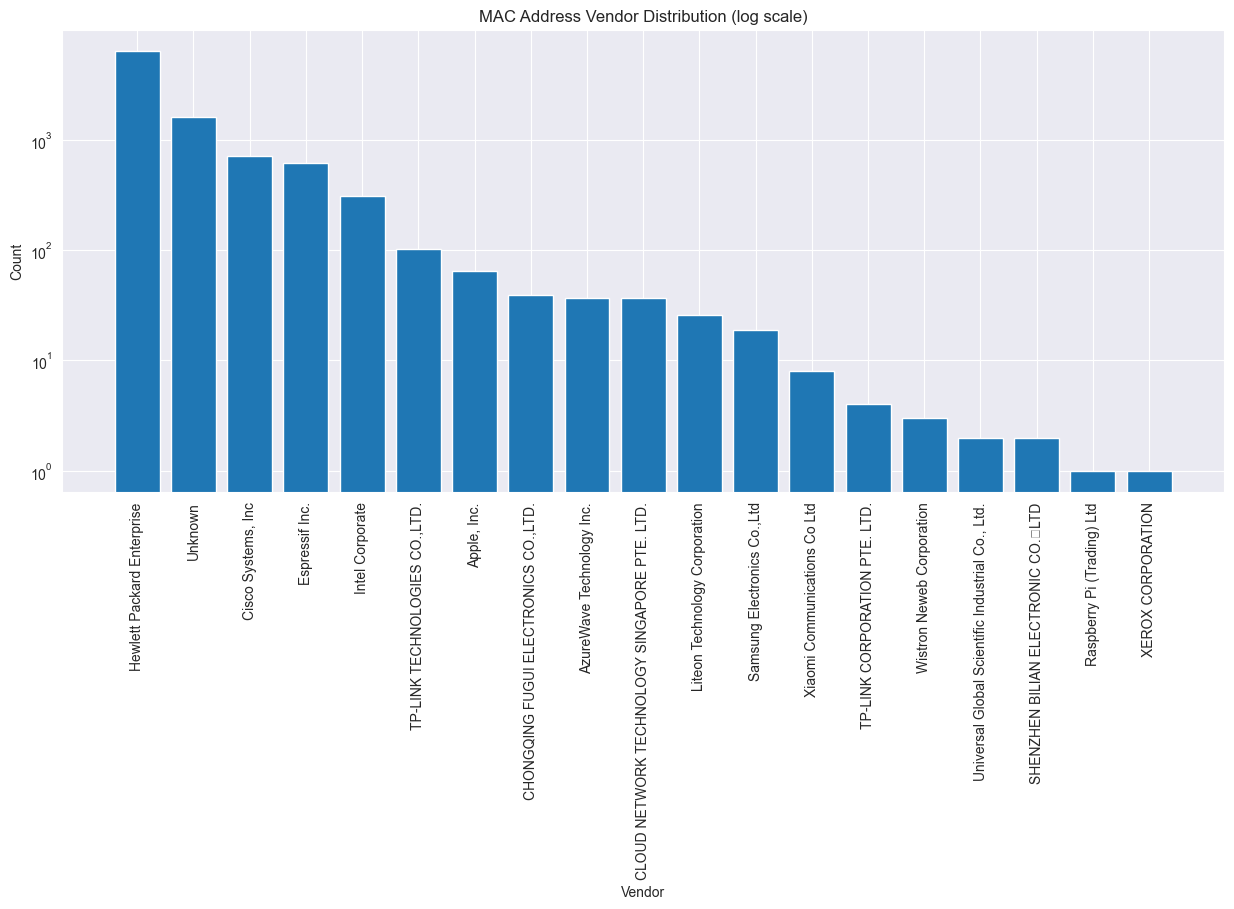

In [47]:
vendor_counts = data_df["vendor"].value_counts()
print(vendor_counts)

plt.figure(figsize=(15, 6))
plt.bar(vendor_counts.index, vendor_counts.values, log=True)
plt.xlabel("Vendor")
plt.ylabel("Count")
plt.title("MAC Address Vendor Distribution (log scale)")
plt.xticks(rotation=90)
plt.show()

In [54]:
data_df

,device,uploaded_file_id,happened_at,rssi,channel,header,payload,id,decoded_headers,translated_header,source_mac,date,minute_of_day,OUI,vendor
11,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-77,1,gAAAAP///////1TX4yu94FTX4yu94KAqhWEjZQ0AAABkADEE,AAVHdWVzdAEIgoQLFiQwSGwDAQEFBAABAAAqAQAyBAwSGG...,f0d94019-6bff-4360-9472-d9ef91133116,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi...",54:d7:e3:2b:bd:e0,2024-11-14,1064,54D7E3,Hewlett Packard Enterprise
73,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNNCnAACJGgAgAAAAAHyP,NaN,8bf9077c-b6ae-4e08-826d-04efa85eba81,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...","{'frame_control': {'raw': 17032, 'protocol_ver...",84:b8:02:66:72:34,2024-11-14,1064,84B802,"Cisco Systems, Inc"
72,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNFDAAAAZLAAgAAAAAACE,NaN,16b54cf4-dce1-454b-962f-1c430f0f5018,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...","{'frame_control': {'raw': 18824, 'protocol_ver...",cc:7b:5c:27:9e:30,2024-11-14,1064,CC7B5C,Espressif Inc.
71,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-86,1,iEkwAFTX4zDSIcx7XCeeMIS4AmZyNDDAAAAXLAAgAAAAANbZ,NaN,709ba6e4-743a-4bf4-bd9f-eb1e5ade6baa,"b""\x88I0\x00T\xd7\xe30\xd2!\xcc{\\'\x9e0\x84\x...","{'frame_control': {'raw': 18824, 'protocol_ver...",cc:7b:5c:27:9e:30,2024-11-14,1064,CC7B5C,Espressif Inc.
70,C8:2E:18:8D:90:A4,1197,2024-11-14 17:44:43,-63,1,iEIwAMx7XCeeMFTX4zDSIYS4AmZyNMCnAACIGgAgAAAAAOJB,NaN,52d4d2b5-9a27-4e7c-aa8a-fd21790e4b81,"b""\x88B0\x00\xcc{\\'\x9e0T\xd7\xe30\xd2!\x84\x...","{'frame_control': {'raw': 17032, 'protocol_ver...",84:b8:02:66:72:34,2024-11-14,1064,84B802,"Cisco Systems, Inc"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-77,1,gAAAAP///////1TX4yu94lTX4yu94jAL1Xl1bg0AAABkADEE,AAtKQVNsb3ZlbnNrbwEIgoQLFiQwSGwDAQEFBAABAAAqAQ...,b9c228b9-97c1-48cc-82cb-2655e7124814,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi...",54:d7:e3:2b:bd:e2,2024-11-14,1067,54D7E3,Hewlett Packard Enterprise
9987,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-78,1,gAAAAP///////1TX4yu94VTX4yu94SALinB1bg0AAABkADEE,AAdlZHVyb2FtAQiChAsWJDBIbAMBAQUEAAEAACoBADIEDB...,3b91ca17-643a-4d5a-812c-e09a50e11ffa,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi...",54:d7:e3:2b:bd:e1,2024-11-14,1067,54D7E3,Hewlett Packard Enterprise
9986,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-78,1,gAAAAP///////1TX4yu94FTX4yu94BALPF11bg0AAABkADEE,AAVHdWVzdAEIgoQLFiQwSGwDAQEFBAABAAAqAQAyBAwSGG...,02d53103-cd7e-4f17-be7a-9782d5f4cc33,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi...",54:d7:e3:2b:bd:e0,2024-11-14,1067,54D7E3,Hewlett Packard Enterprise
9991,C8:2E:18:8D:90:A4,1197,2024-11-14 17:47:20,-60,1,gAAAAP///////1TX4zDSIVTX4zDSIQCVRNIsaw0AAABkADEE,AAdlZHVyb2FtAQiChAsWJDBIbAMBAQUEAAEAACoBADIEDB...,9a62214f-007f-4241-bd43-60673c79fd51,b'\x80\x00\x00\x00\xff\xff\xff\xff\xff\xffT\xd...,"{'frame_control': {'raw': 128, 'protocol_versi...",54:d7:e3:30:d2:21,2024-11-14,1067,54D7E3,Hewlett Packard Enterprise


In [51]:
data_norm = pd.json_normalize(data_df["translated_header"])
data_norm["frame_control.frame_type"].value_counts()

frame_control.frame_type
Management    7094
Data          2895
Name: count, dtype: int64

In [52]:
group_counts = data_norm.groupby(
    ["frame_control.frame_type", "frame_control.subtype"]
).size().reset_index(name="count")

group_counts.sort_values("count", ascending=False, inplace=True)

group_counts

,frame_control.frame_type,frame_control.subtype,count
5,Management,Beacon,5833
0,Data,Data,1433
2,Data,QoS Data,1033
7,Management,Probe Response,591
4,Management,Action,423
1,Data,Null Function (No Data),349
6,Management,Probe Request,246
3,Data,QoS Null,80
8,Management,Timing Advertisement (11v),1


In [53]:
data_norm

,duration_id,qos_control_raw,ht_control_raw,frame_body,frame_control.raw,frame_control.protocol_version,frame_control.frame_type,frame_control.subtype,frame_control.to_ds,frame_control.from_ds,...,addresses.address2,addresses.address3,addresses.address4,sequence_control.raw,sequence_control.fragment_number,sequence_control.sequence_number,frame_body.ssid,frame_body.supported_rates,frame_body.extended_rates,frame_body.vendor_specific
0,0,NaN,None,856123650d00000064003104,128,0,Management,Beacon,False,False,...,54:d7:e3:2b:bd:e0,54:d7:e3:2b:bd:e0,None,10912,0,682,NaN,NaN,NaN,NaN
1,48,0.0,None,891a0020000000007c8f,17032,0,Data,QoS Data,False,True,...,54:d7:e3:30:d2:21,84:b8:02:66:72:34,None,42960,0,2685,NaN,NaN,NaN,NaN
2,48,0.0,None,192c0020000000000084,18824,0,Data,QoS Data,True,False,...,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,None,49232,0,3077,NaN,NaN,NaN,NaN
3,48,0.0,None,172c002000000000d6d9,18824,0,Data,QoS Data,True,False,...,cc:7b:5c:27:9e:30,84:b8:02:66:72:34,None,49200,0,3075,NaN,NaN,NaN,NaN
4,48,0.0,None,881a002000000000e241,17032,0,Data,QoS Data,False,True,...,54:d7:e3:30:d2:21,84:b8:02:66:72:34,None,42944,0,2684,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0,NaN,None,d579756e0d00000064003104,128,0,Management,Beacon,False,False,...,54:d7:e3:2b:bd:e2,54:d7:e3:2b:bd:e2,None,2864,0,179,NaN,NaN,NaN,NaN
9985,0,NaN,None,8a70756e0d00000064003104,128,0,Management,Beacon,False,False,...,54:d7:e3:2b:bd:e1,54:d7:e3:2b:bd:e1,None,2848,0,178,NaN,NaN,NaN,NaN
9986,0,NaN,None,3c5d756e0d00000064003104,128,0,Management,Beacon,False,False,...,54:d7:e3:2b:bd:e0,54:d7:e3:2b:bd:e0,None,2832,0,177,NaN,NaN,NaN,NaN
9987,0,NaN,None,44d22c6b0d00000064003104,128,0,Management,Beacon,False,False,...,54:d7:e3:30:d2:21,54:d7:e3:30:d2:21,None,38144,0,2384,NaN,NaN,NaN,NaN
